In [298]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from typing import Dict, Tuple, List

In [209]:
%matplotlib notebook

In [322]:
EMPTY = 0
THRESHOLD = 0.4

In [235]:
def schelling_model(grid: np.ndarray, max_iter: int) -> List[np.ndarray]:
    grids = [grid]
    agent_types = np.unique(grid)
    updated = True
    i = 0
    while updated and i < max_iter:
        grid, updated = schelling_ca(grid, agent_types)
        grids.append(grid)
        i += 1
    return grids

In [236]:
def schelling_ca(grid: np.ndarray, agent_types: np.ndarray) -> Tuple[np.ndarray, bool]:
    neigh_fractions = {a_type: compute_fractions(grid, a_type) for a_type in agent_types}
    return relocate_agents(np.copy(grid), neigh_fractions)

In [248]:
def compute_fractions(grid: np.ndarray, agent_type: int) -> np.ndarray:
    n_rows, n_cols = grid.shape
#     fractions = np.empty(grid.shape)
    fractions = dict()
    for i in range(n_rows):
        for j in range(n_cols):
            neigh = neighbourhood(grid, i, j)
            n_preffered = np.count_nonzero(neigh == agent_type)
            n_all = np.count_nonzero(neigh != EMPTY)
            fractions[i, j] = (n_preffered, n_all)# if n_all else 0
    return fractions

In [292]:
def relocate_agents(grid: np.ndarray, fractions: Dict[int, np.ndarray]) -> Tuple[np.ndarray, bool]:
    n_rows, n_cols = grid.shape
    rows, cols = list(range(n_rows)), list(range(n_cols))
    np.random.shuffle(rows), np.random.shuffle(cols)
    relocated = False
    for i in rows:
        for j in cols:
            agent_type = grid[i, j]
            n_preffered, n_all = fractions[agent_type][i,j][0], fractions[agent_type][i,j][1]
            b = n_preffered / n_all if n_all else 1
            if agent_type != EMPTY and b < THRESHOLD:
                neigh = neigh_indices(grid, i, j)
                new_indices = find_better_spot(grid, fractions[agent_type], i, j)
                if new_indices:
                    grid[new_indices] = agent_type
                    grid[i, j] = EMPTY
                    relocated = True
    return grid, relocated

In [327]:
def find_better_spot(grid: np.ndarray, fractions: np.ndarray, i: int, j: int) -> Tuple[int, int]:
    neigh_coords = neigh_indices(grid, i, j)
    np.random.shuffle(neigh_coords)
    for row, col in neigh_coords:
        n_preffered, n_all = fractions[row, col][0] - 1, fractions[row, col][1] - 1
        b = n_preffered / n_all if n_all else 1
        if grid[row, col] == EMPTY and b >= THRESHOLD:
            return row, col
    
    n_preffered, n_all = fractions[i, j][0], fractions[i, j][1]
    self_b = n_preffered / n_all if n_all else 1
    for row, col in neigh_coords:
        n_preffered, n_all = fractions[row, col][0] - 1, fractions[row, col][1] - 1
        b = n_preffered / n_all if n_all else 1
        if grid[row, col] == EMPTY and b > self_b:
            return row, col

In [240]:
def neighbourhood(grid: np.ndarray, i: int, j: int) -> np.ndarray:
    return np.array([grid[i, j] for i, j in neigh_indices(grid, i, j)])

In [241]:
def neigh_indices(grid: np.ndarray, i: int, j: int) -> List[Tuple[int, int]]:
    n, _ = grid.shape
    candidates = [
        (i-1, j-1),
        (i-1, j),
        (i-1, j+1),
        (i, j-1),
        (i, j+1),
        (i+1, j-1),
        (i+1, j),
        (i+1, j+1),
    ]
    return [(i,j) for (i,j) in candidates if i>=0 and j>=0 and i<n and j<n]

In [303]:
colors = [(1, 1, 1), (1, 0, 0), (0, 0, 1)]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=3)
def plot_grid(grid: np.ndarray):
    return plt.imshow(grid, cmap=cmap)    

In [320]:
def visualize(grids: List[np.ndarray]):
    fig = plt.figure(figsize=(10,10))
    im = plot_grid(grids[0])
    ani = FuncAnimation(fig, plot_grid, grids)
    writergif = PillowWriter(fps=5) 
    ani.save(f'animation.gif', writer=writergif)
    fig.colorbar(im)
    plt.show()

In [313]:
def create_grid(size: int, densities: Dict[int, float]) -> np.ndarray:
    grid = []
    for field_type, density in densities.items():
        n_fields = int(size * size * density)
        grid += [field_type for _ in range(n_fields)]
    grid += [EMPTY for _ in range(size * size - len(grid))]
    np.random.shuffle(grid)
    return np.array(grid).reshape((size, size))

In [245]:
a = np.array([[1,0,2], [0,0,2], [1,1,2]])
a

array([[1, 0, 2],
       [0, 0, 2],
       [1, 1, 2]])

In [333]:
n_all = 110_000
white = 60_371 / n_all
black = 14_675 / n_all
empty = 1 - white - black
initial = create_grid(100, {1: white, 2: black})

In [334]:
grids = schelling_model(initial, max_iter=1000)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


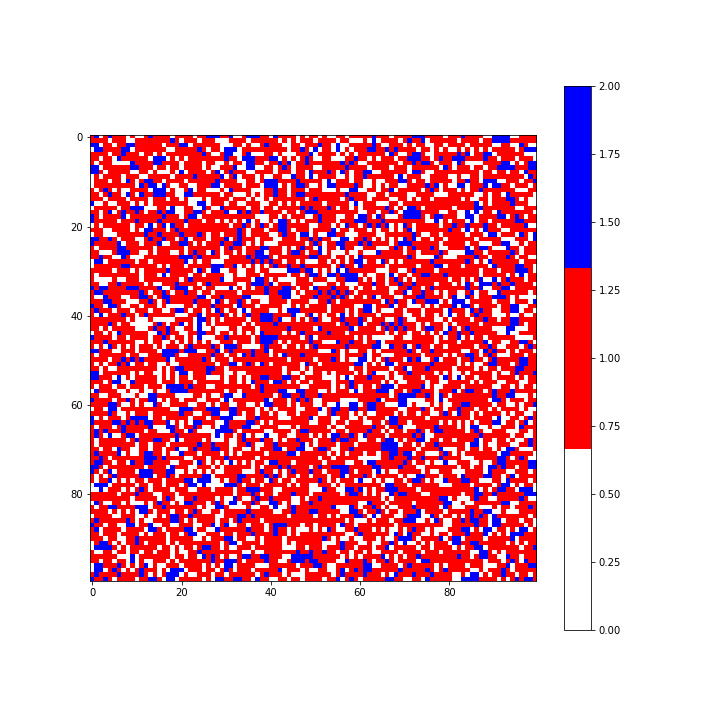

In [330]:
visualize(grids)

<IPython.core.display.Javascript object>


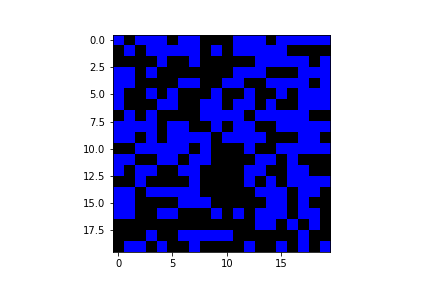

In [301]:
plot_grid(initial)
plt.show()

In [150]:
a = schelling_ca(a, np.array([1,2]))
a

array([[0, 0, 2],
       [1, 1, 2],
       [1, 0, 2]])

In [132]:
a[(2, 1)]

1

In [78]:
relocate_agents(a, None)

([2, 1, 0], [2, 1, 0])

In [18]:
def pad(grid: np.ndarray) -> np.ndarray:
    return np.pad(grid, (1), constant_values=(EMPTY))

In [19]:
def unpad(grid: np.ndarray) -> np.ndarray:
    return grid[1:-1, 1:-1]

In [163]:
a = np.array([[1,0,2], [0,0,2], [1,1,2]])
a

array([[1, 0, 2],
       [0, 0, 2],
       [1, 1, 2]])

In [123]:
compute_fractions(a, 1)

[0 0 0]
[1 2 0 0 2]
[0 0 2]
[1 0 0 1 1]
[1 0 2 0 2 1 1 2]
[0 2 0 1 2]
[0 0 1]
[0 0 2 1 2]
[0 2 1]


array([[0.        , 0.33333333, 0.        ],
       [1.        , 0.5       , 0.33333333],
       [1.        , 0.33333333, 0.5       ]])

In [124]:
compute_fractions(a, 2)

[0 0 0]
[1 2 0 0 2]
[0 0 2]
[1 0 0 1 1]
[1 0 2 0 2 1 1 2]
[0 2 0 1 2]
[0 0 1]
[0 0 2 1 2]
[0 2 1]


array([[0.        , 0.66666667, 1.        ],
       [0.        , 0.5       , 0.66666667],
       [0.        , 0.66666667, 0.5       ]])

In [40]:
a = [1,2,3,4]
np.random.shuffle(a)
a

[3, 4, 1, 2]

In [8]:
schelling(np.ones((2,2), dtype=int))

array([1])